# <a id='toc1_'></a>[CLIP Analysis](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [CLIP Analysis](#toc1_)    
  - [Analyze CLIP similarity on datasets](#toc1_1_)    
  - [Analyze Classifier Confidence on datasets](#toc1_2_)    
  - [Visualize the analysis](#toc1_3_)    
    - [KDE Plot](#toc1_3_1_)    
    - [get Stats](#toc1_3_2_)    
    - [Scatter Plots](#toc1_3_3_)    
    - [Histograms](#toc1_3_4_)    
  - [Combined Visualization](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from torchvision.models import resnet18

from tools import analysis, classes, data, synth

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

This notebook is used to analyze the generated images and evaluation results between a class pair.

Before running this notebook, prepare a directory with the following structure:
```bash
.
├── dataset1
│   ├── train (2 class)
│   │   ├── class1
│   │   │   ├── image1.jpg
│   │   │   ├── image2.jpg
│   │   │   └── ...
│   │   └── class2
│   │       ├── image1.jpg
│   │       ├── image2.jpg
│   │       └── ...
│   ├── val (2 class)
│   │   ├── class1
│   │   │   ├── image1.jpg
│   │   │   ├── image2.jpg
│   │   │   └── ...
│   │   └── class2
│   │       ├── image1.jpg
│   │       ├── image2.jpg
│   │       └── ...
│   └── synthetic (2 class)
│       ├── class1
│       │   ├── image1.jpg
│       │   ├── image2.jpg
│       │   └── ...
│       └── class2
│           ├── image1.jpg
│           ├── image2.jpg
│           └── ...
```

In [3]:
dataset_type = "poc/imagenette"  # path to 2-class dataset
class_pairs = ("n02979186", "n03000684")  # Cassette_player, Chain_saw
prompt_format = "a photo of a <class_name>"
ds = "Imagenette"

# dataset_type = "poc/woof"  # poc, dev, data("prod")
# class_pairs = ("n02087394", "n02088364") # Rhodesian_ridgeback, Beagle
# prompt_format = "a photo of a <class_name>, a type of dog"
# ds = "Imagewoof"

cache_path = f"./{dataset_type}"
genInput_dir = f"{dataset_type}/train2"
val_path = f"{dataset_type}/val2"
synth_path = f"{dataset_type}/synthetic2"
metadata_path = f"{dataset_type}/metadata/analysis" # create the metadata folder if it does not exist

In [4]:
class_list = list(class_pairs)
class_name_pairs = (
    classes.IMAGENET2012_CLASSES[class_pairs[0]],
    classes.IMAGENET2012_CLASSES[class_pairs[1]],
)

In [5]:
prompts, negative_prompts = synth.createPrompts(
    class_name_pairs,
    prompt_structure=prompt_format,
    negative_prompt=None,
)

Info: Negative prompt not provided, returning as None.


## <a id='toc1_1_'></a>[Analyze CLIP similarity on datasets](#toc0_)

In [6]:
# prepare data for clip model
data.cacheGenData(
    genInput_dir, "imagenet2_inputImg_clip", save_path=cache_path, do_rescale=False
)
data.cacheGenData(
    val_path, "imagenet2_val_clip", save_path=cache_path, do_rescale=False
)
data.cacheGenData(
    synth_path, "imagenet2_synth_clip", save_path=cache_path, do_rescale=False
)
genInput_dataset = data.loadData("imagenet2_inputImg_clip", cache_path=cache_path)
val_dataset = data.loadData("imagenet2_val_clip", cache_path=cache_path)
synth_dataset = data.loadData("imagenet2_synth_clip", cache_path=cache_path)
clip_dataset_dict = {
    "train": genInput_dataset,
    "val": val_dataset,
    "synth": synth_dataset,
}

imagenet2_inputImg_clip.pt dataset saved to ./poc/woof
imagenet2_val_clip.pt dataset saved to ./poc/woof
imagenet2_synth_clip.pt dataset saved to ./poc/woof
imagenet2_inputImg_clip.pt dataset loaded from ./poc/woof
imagenet2_val_clip.pt dataset loaded from ./poc/woof
imagenet2_synth_clip.pt dataset loaded from ./poc/woof


In [7]:
clip_df = analysis.analyze_clip(
    prompts,
    clip_dataset_dict,
    clip_model_path="openai/clip-vit-large-patch14",
    device=device,
)
clip_df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
clip_df.to_csv(f"{metadata_path}/clip_analyze_{synth_path.replace('/','_')}.csv", index=False)

## <a id='toc1_2_'></a>[Analyze Classifier Confidence on datasets](#toc0_)

In [ ]:
# prepare data for classifier
data.cacheValData(genInput_dir, "imagenet2_inputImg_clfval", save_path=cache_path)
data.cacheValData(val_path, "imagenet2_val_clfval", save_path=cache_path)
data.cacheValData(synth_path, "imagenet2_synth_clfval", save_path=cache_path)

genInput_dataset_v = data.loadData("imagenet2_inputImg_clfval", cache_path=cache_path)
val_dataset_v = data.loadData("imagenet2_val_clfval", cache_path=cache_path)
synth_dataset_v = data.loadData("imagenet2_synth_clfval", cache_path=cache_path)

val_dataset_dict = {
    "train": genInput_dataset_v,
    "val": val_dataset_v,
    "synth": synth_dataset_v,
}

imagenet2_inputImg_clfval.pt dataset saved to ./poc/imagenette
imagenet2_val_clfval.pt dataset saved to ./poc/imagenette
imagenet2_synth_clfval.pt dataset saved to ./poc/imagenette
imagenet2_inputImg_clfval.pt dataset loaded from ./poc/imagenette
imagenet2_val_clfval.pt dataset loaded from ./poc/imagenette
imagenet2_synth_clfval.pt dataset loaded from ./poc/imagenette


- For this section, we will analyze the classifier confidence on the 2 class datasets.
- So we will use the classifier to predict the class of the images and analyze the confidence of the classifier on the images.
- To do that, the predictions of the classifier needs to be remapped to the two classes of the dataset.
- Point val2_path to the directory containing the *full* validation images of the dataset that the classifier was tested on, to get the class_idx map.

In [ ]:
# get base model class_to_idx
val2_path = f"{dataset_type}/val" # path to the full validation dataset that the classifier was tested on
data.cacheValData(val2_path, "imagenet2_val", save_path=cache_path)
val2_dataset = data.loadData("imagenet2_val", cache_path=cache_path)
base_class_to_idx = val2_dataset.class_to_idx
base_idx_to_class = {v: k for k, v in base_class_to_idx.items()}

# get idx of class_pairs
base_class_idx = [base_class_to_idx[c] for c in class_pairs]
base_class_idx

imagenet2_val.pt dataset saved to ./poc/imagenette
imagenet2_val.pt dataset loaded from ./poc/imagenette


[2, 3]

Now, load the classifiers to evaluate the confidence of the classifier on the images.

In [ ]:
eval_model_path = f"output/resnet18/dev-{dataset_type.split('/')[1]}-base/model_200.pth"
model = resnet18(weights=None, num_classes=10)
checkpoint = torch.load(eval_model_path)
if "setup" in checkpoint:
    if checkpoint["setup"]["distributed"]:
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint["model"], "module."
        )
    model.load_state_dict(checkpoint["model"])
else:
    model.load_state_dict(checkpoint)
model.to(device)
model.eval()
print("Model loaded")

Model loaded


In [ ]:
base_clf_df = analysis.analyze_classifier_confidence(
    val_dataset_dict=val_dataset_dict,
    model=model,
    base_class_idx=base_class_idx,
    device=device,
)
base_clf_df.groupby("type").describe()["correct"]["mean"]

100%|██████████| 3/3 [00:40<00:00, 13.39s/it]


type
synth    0.915881
train    1.000000
val      0.963661
Name: mean, dtype: float64

In [ ]:
eval_model_path = f"output/resnet18/dev-{dataset_type.split('/')[1]}-mix/model_200.pth"
model = resnet18(weights=None, num_classes=10)
checkpoint = torch.load(eval_model_path)
if "setup" in checkpoint:
    if checkpoint["setup"]["distributed"]:
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint["model"], "module."
        )
    model.load_state_dict(checkpoint["model"])
else:
    model.load_state_dict(checkpoint)
model.to(device)
model.eval()
print("Model loaded")

Model loaded


In [ ]:
mix_clf_df = analysis.analyze_classifier_confidence(
    val_dataset_dict=val_dataset_dict,
    model=model,
    base_class_idx=base_class_idx,
    suffix="_mix",
    device=device,
)
mix_clf_df.groupby("type").describe()["correct_mix"]["mean"]

100%|██████████| 3/3 [00:33<00:00, 11.33s/it]


type
synth    1.00000
train    1.00000
val      0.97039
Name: mean, dtype: float64

In [ ]:
# join clip and clf dataframes
df = pd.merge(
    clip_df,
    base_clf_df,
    on=[
        "dataset",
        "type",
        "file_path",
        "file_name",
        "actual_class",
        "actual_classname",
    ],
)

In [ ]:
# join clip and clf dataframes
df = pd.merge(
    df,
    mix_clf_df,
    on=[
        "dataset",
        "type",
        "file_path",
        "file_name",
        "actual_class",
        "actual_classname",
    ],
)

In [ ]:
df.to_csv(f"{metadata_path}/clip_clf_{synth_path.replace('/','_')}.csv", index=False)

## <a id='toc1_3_'></a>[Visualize the analysis](#toc0_)

In [6]:
df = pd.read_csv(f"{metadata_path}/clip_clf_{synth_path.replace('/','_')}.csv")

In [69]:
# rename column x_sim to delta_sim if x_sim is in df
if "x_sim" in df.columns:
    df.rename(columns={"x_sim": "delta_sim"}, inplace=True)
    df.to_csv(f"{metadata_path}/clip_clf_{synth_path.replace('/','_')}.csv")

In [70]:
df.head()

,Unnamed: 0,dataset,type,file_path,file_name,actual_class,actual_classname,clip_pred_class,clip_pred_classname,cos_sim,...,sim_0,sim_1,clf_pred_class,clf_pred_classname,y_conf,correct,clf_pred_class_mix,clf_pred_classname_mix,y_conf_mix,correct_mix
0,0,poc/imagenette,train,poc\imagenette\train\n02979186\ILSVRC2012_val_...,ILSVRC2012_val_00000557.JPEG,n02979186,cassette player,n02979186,cassette player,24.939833,...,24.939833,14.093545,n02979186,cassette player,0.997757,1,n02979186,cassette player,0.999938,1
1,1,poc/imagenette,train,poc\imagenette\train\n02979186\ILSVRC2012_val_...,ILSVRC2012_val_00002034.JPEG,n02979186,cassette player,n02979186,cassette player,28.411257,...,28.411257,12.543082,n02979186,cassette player,0.981461,1,n02979186,cassette player,0.996849,1
2,2,poc/imagenette,train,poc\imagenette\train\n02979186\ILSVRC2012_val_...,ILSVRC2012_val_00003944.JPEG,n02979186,cassette player,n02979186,cassette player,28.131178,...,28.131178,12.227724,n02979186,cassette player,0.999959,1,n02979186,cassette player,0.997707,1
3,3,poc/imagenette,train,poc\imagenette\train\n02979186\ILSVRC2012_val_...,ILSVRC2012_val_00005866.JPEG,n02979186,cassette player,n02979186,cassette player,24.653704,...,24.653704,10.687343,n02979186,cassette player,0.999952,1,n02979186,cassette player,0.999879,1
4,4,poc/imagenette,train,poc\imagenette\train\n02979186\ILSVRC2012_val_...,ILSVRC2012_val_00006787.JPEG,n02979186,cassette player,n02979186,cassette player,25.885921,...,25.885921,14.406040,n02979186,cassette player,0.999941,1,n02979186,cassette player,0.999969,1


### <a id='toc1_3_1_'></a>[KDE Plot](#toc0_)

<Axes: title={'center': 'CLIP Score for Imagenette: Original'}, xlabel="Prompt: 'a photo of a cassette player'", ylabel="Prompt: 'a photo of a chain saw, chainsaw'">

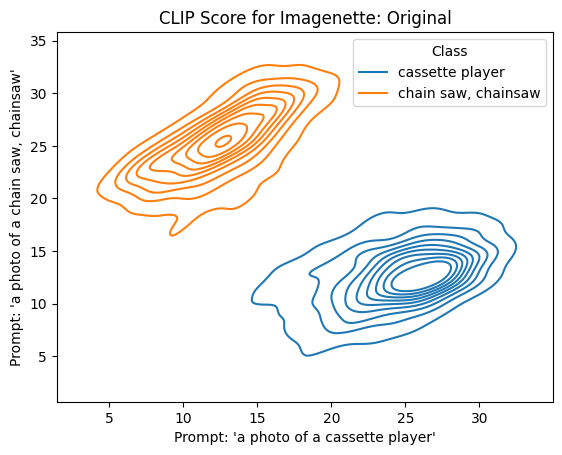

In [71]:
input = df[df["type"] == "train"].copy()
ds_name = f"{ds}: Original"
analysis.plot_kde(
    input,
    ds_name=ds_name,
    prompt_format=prompt_format,
    save=f"{metadata_path}/similarity_kde_train_{synth_path.replace('/','_')}.svg",
)

<Axes: title={'center': 'CLIP Score for Imagenette: Original+Synthetic'}, xlabel="Prompt: 'a photo of a cassette player'", ylabel="Prompt: 'a photo of a chain saw, chainsaw'">

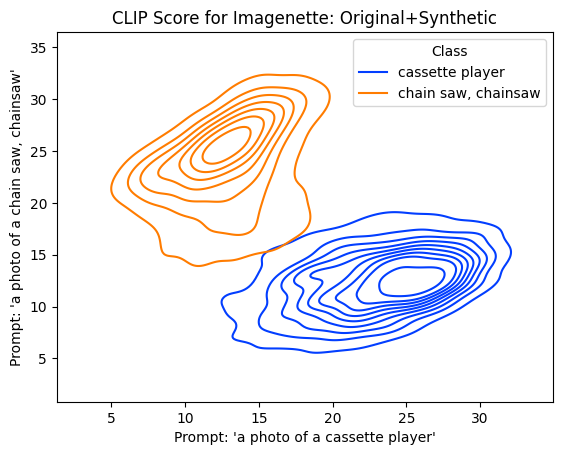

In [72]:
input = df[(df["type"] == "train") | (df["type"] == "synth")].copy()
ds_name = f"{ds}: Original+Synthetic"
analysis.plot_kde(
    input,
    ds_name=ds_name,
    prompt_format=prompt_format,
    save=f"{metadata_path}/similarity_kde_mix_{synth_path.replace('/','_')}.svg",
    palette="bright",
)

<Axes: title={'center': 'CLIP Score for Imagenette: Synthetic'}, xlabel="Prompt: 'a photo of a cassette player'", ylabel="Prompt: 'a photo of a chain saw, chainsaw'">

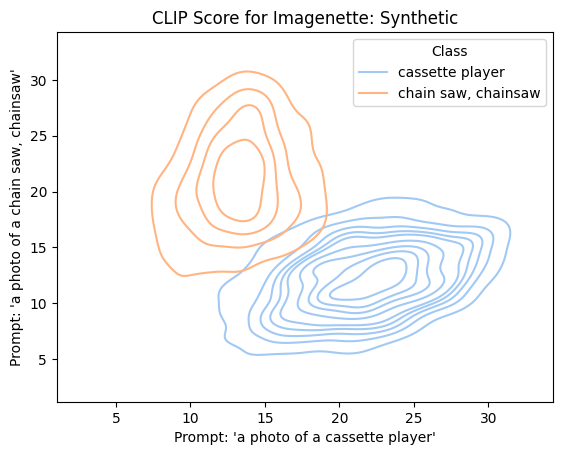

In [73]:
input = df[df["type"] == "synth"].copy()
ds_name = f"{ds}: Synthetic"
analysis.plot_kde(
    input,
    ds_name=ds_name,
    prompt_format=prompt_format,
    save=f"{metadata_path}/similarity_kde_synth_{synth_path.replace('/','_')}.svg",
    palette="pastel",
)

<Axes: title={'center': 'CLIP Score for Imagenette: Validation'}, xlabel="Prompt: 'a photo of a cassette player'", ylabel="Prompt: 'a photo of a chain saw, chainsaw'">

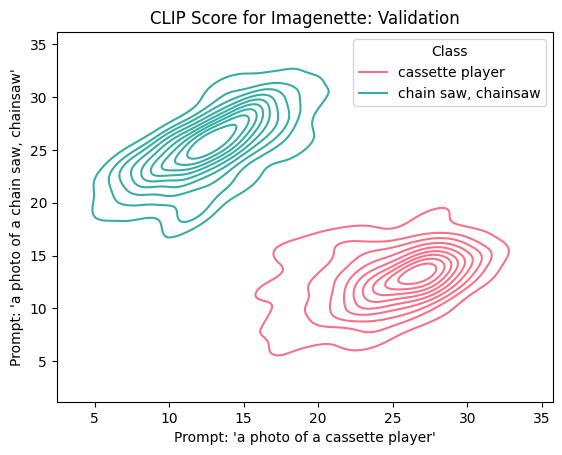

In [74]:
input = df[df["type"] == "val"].copy()
ds_name = f"{ds}: Validation"
analysis.plot_kde(
    input,
    ds_name=ds_name,
    prompt_format=prompt_format,
    save=f"{metadata_path}/similarity_kde_val_{synth_path.replace('/','_')}.svg",
    palette="husl",
)

### <a id='toc1_3_2_'></a>[get Stats](#toc0_)

In [75]:
analysis.getStats(df, metadata_path, synth_path)

Stats saved to poc/imagenette/metadata/analysisc


In [76]:
analysis.analyze_clf_stats(df, class_pairs=class_pairs, save_csv=f"{metadata_path}/stats_clf_{synth_path.replace('/','_')}.csv")

### <a id='toc1_3_3_'></a>[Scatter Plots](#toc0_)

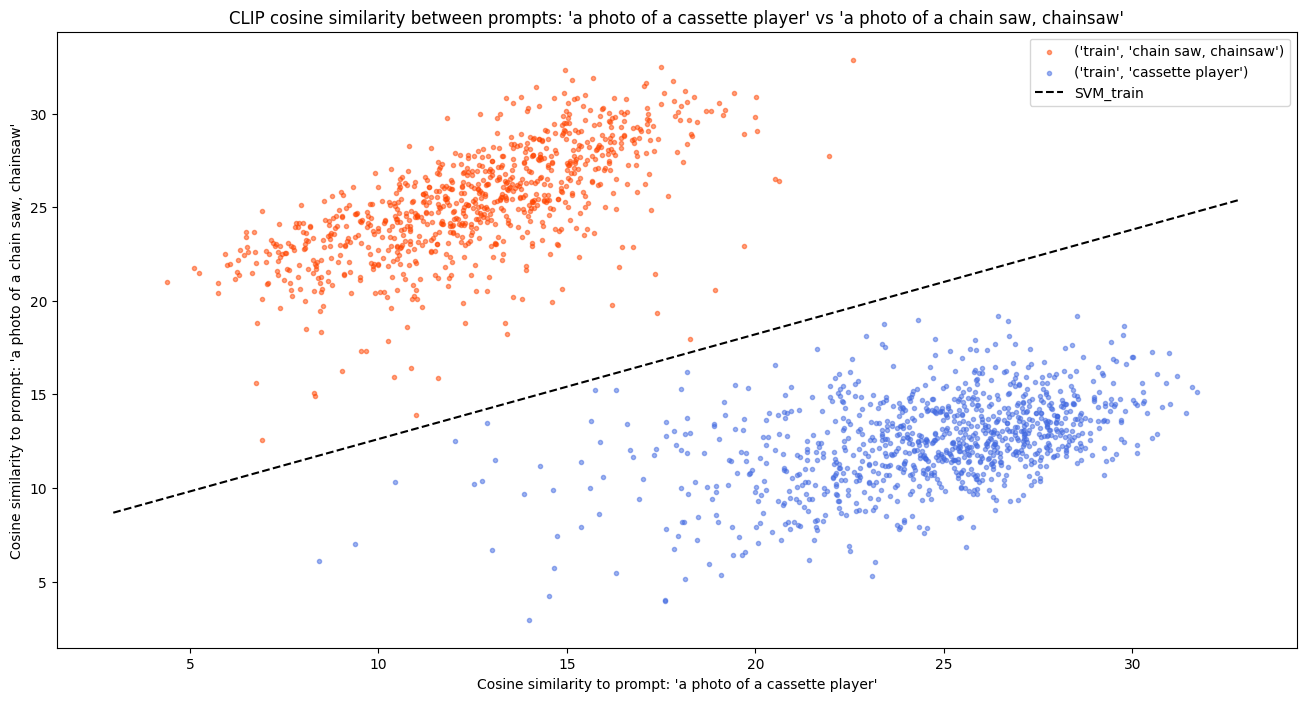

In [77]:
analysis.viz_scatter_prompts(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    plot_type=["train"],
    prompts=prompts,
    save=f"{metadata_path}/scatter_train_{synth_path.replace('/','_')}.svg",
)

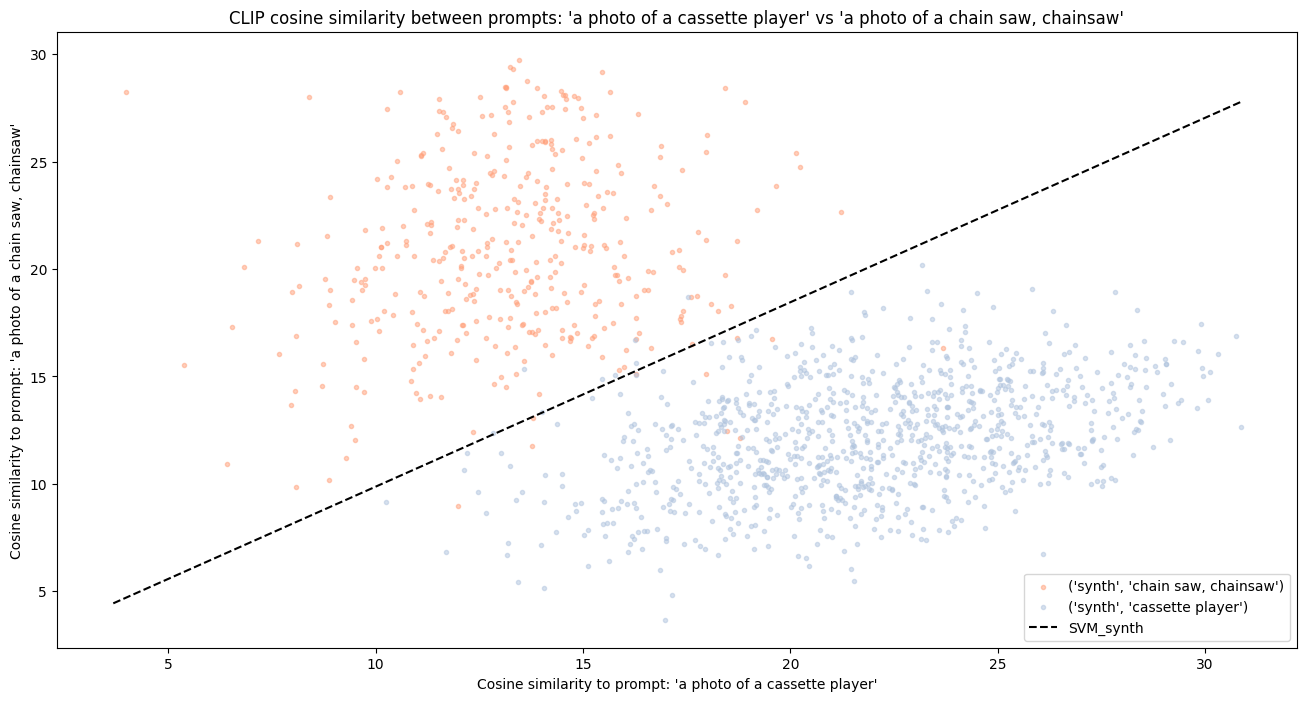

In [78]:
analysis.viz_scatter_prompts(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    plot_type=["synth"],
    prompts=prompts,
    save=f"{metadata_path}/scatter_synth_{synth_path.replace('/','_')}.svg",
)

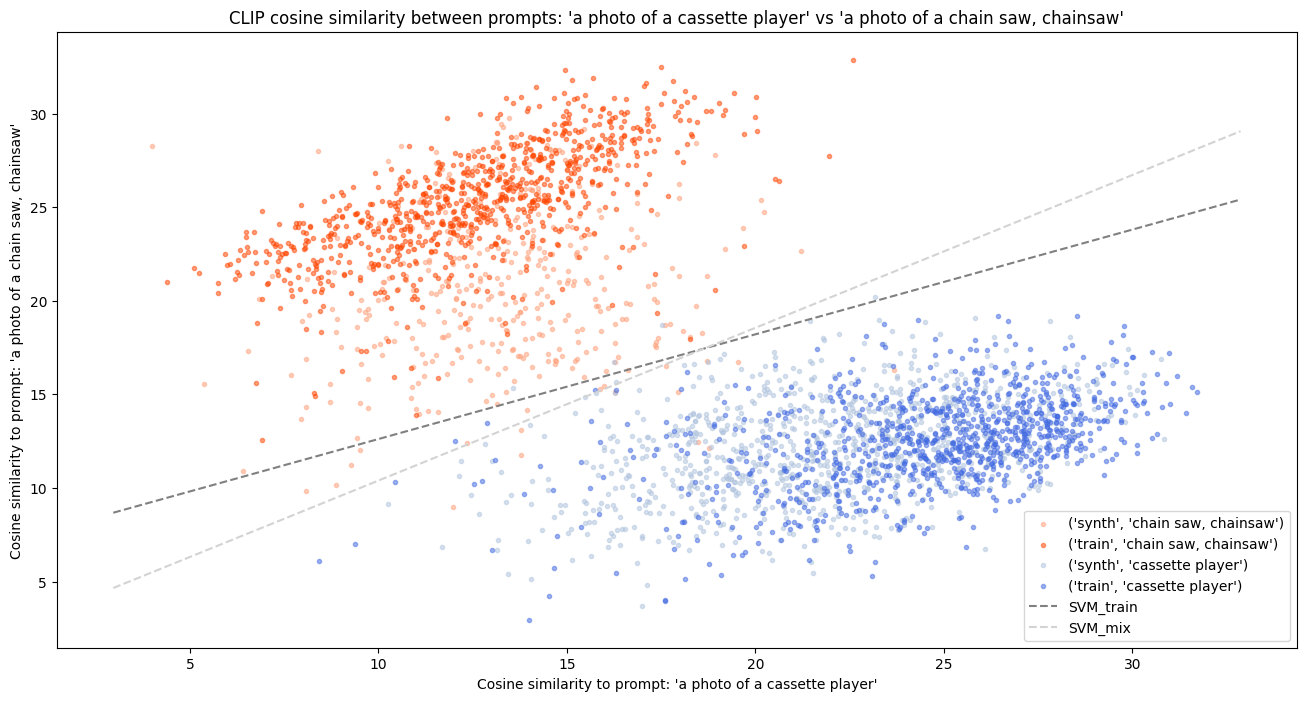

In [79]:
analysis.viz_scatter_prompts(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    plot_type=["synth", "train"],
    prompts=prompts,
    train_sep_line=True,
    mix_sep_line=True,
    save=f"{metadata_path}/scatter_comb_{synth_path.replace('/','_')}.svg",
)

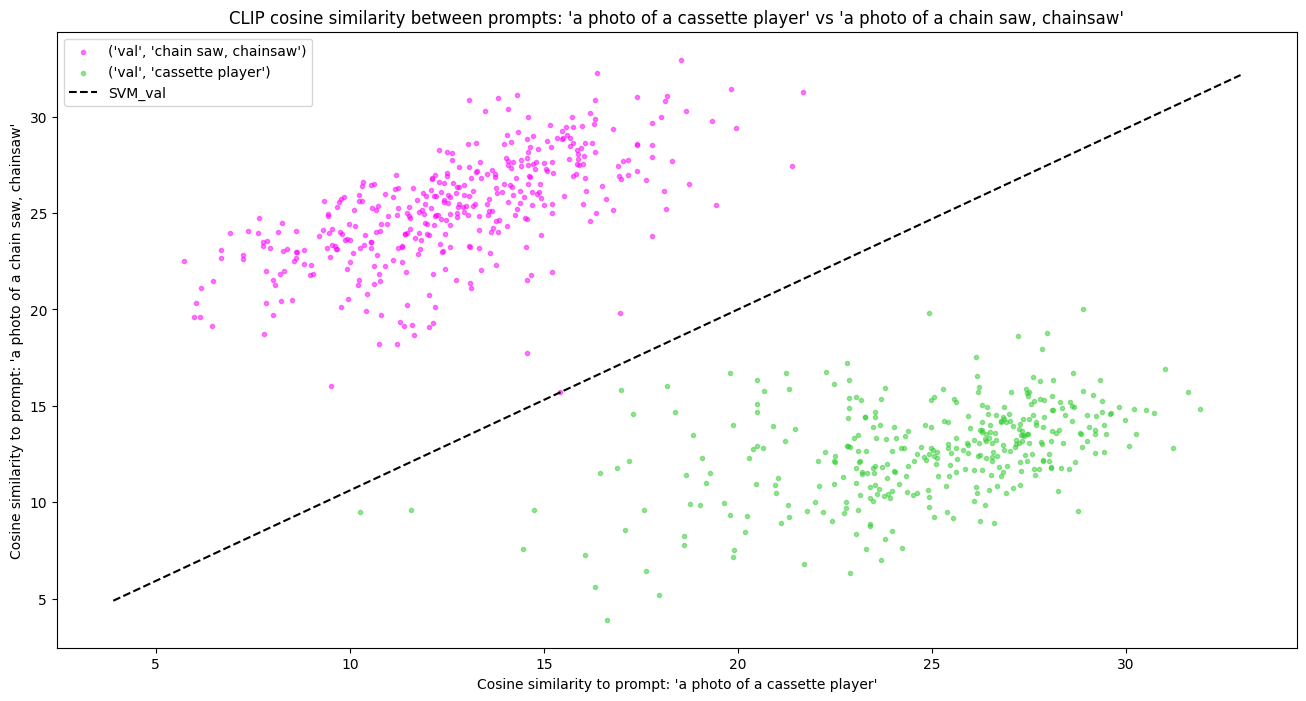

In [80]:
analysis.viz_scatter_prompts(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    plot_type=["val"],
    prompts=prompts,
    save=f"{metadata_path}/scatter_val_{synth_path.replace('/','_')}.svg",
)

### <a id='toc1_3_4_'></a>[Histograms](#toc0_)

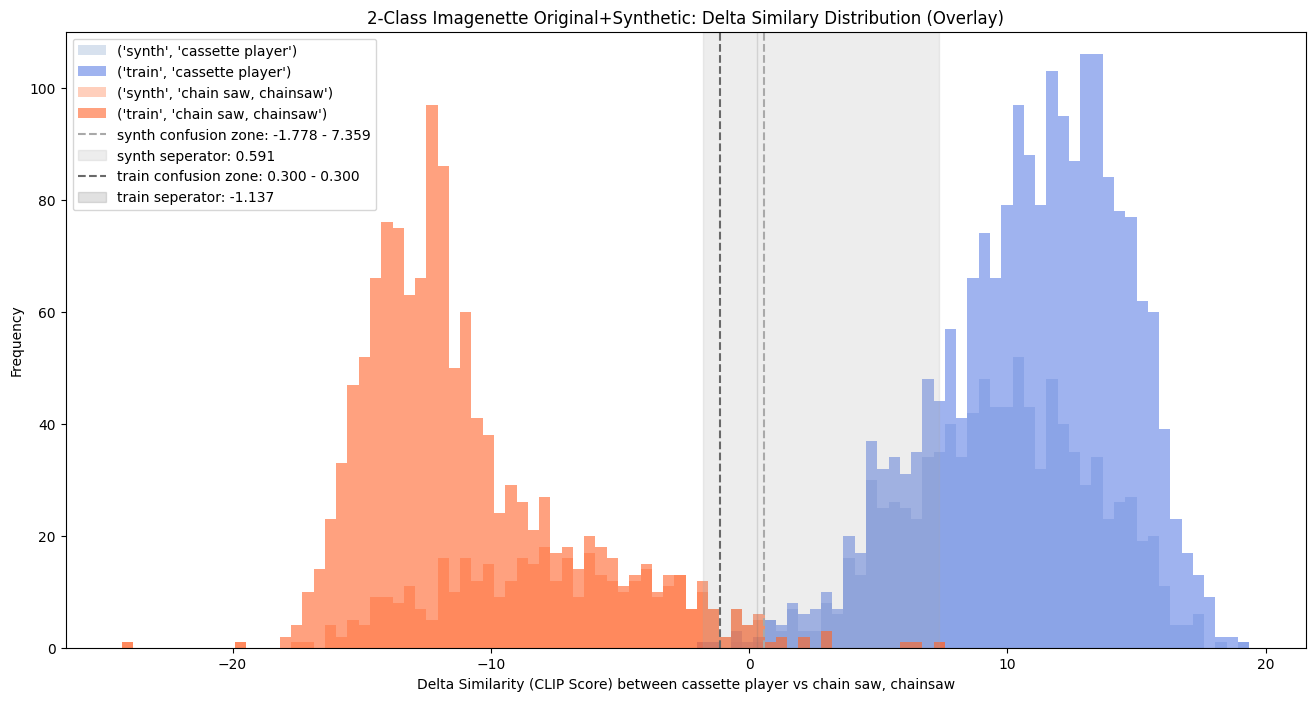

{'synth': (-1.7783145904541016, 0.5910205841064453, 7.358856201171875),
 'train': (0.2996768951416015, -1.1365580558776855, 0.2996768951416015)}

In [7]:
analysis.viz_hist_zone(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    bins=100,
    plot_type=["train", "synth"],
    # manual_confusion_range=(
    #     -0.0780787318944931,
    #     -0.0267576798796653,
    #     0.0206701457500457,
    # ),
    save=f"{metadata_path}/hist_comb_{synth_path.replace('/','_')}.svg",
    title=f"2-Class {ds} Original+Synthetic: Delta Similary Distribution (Overlay)",
)

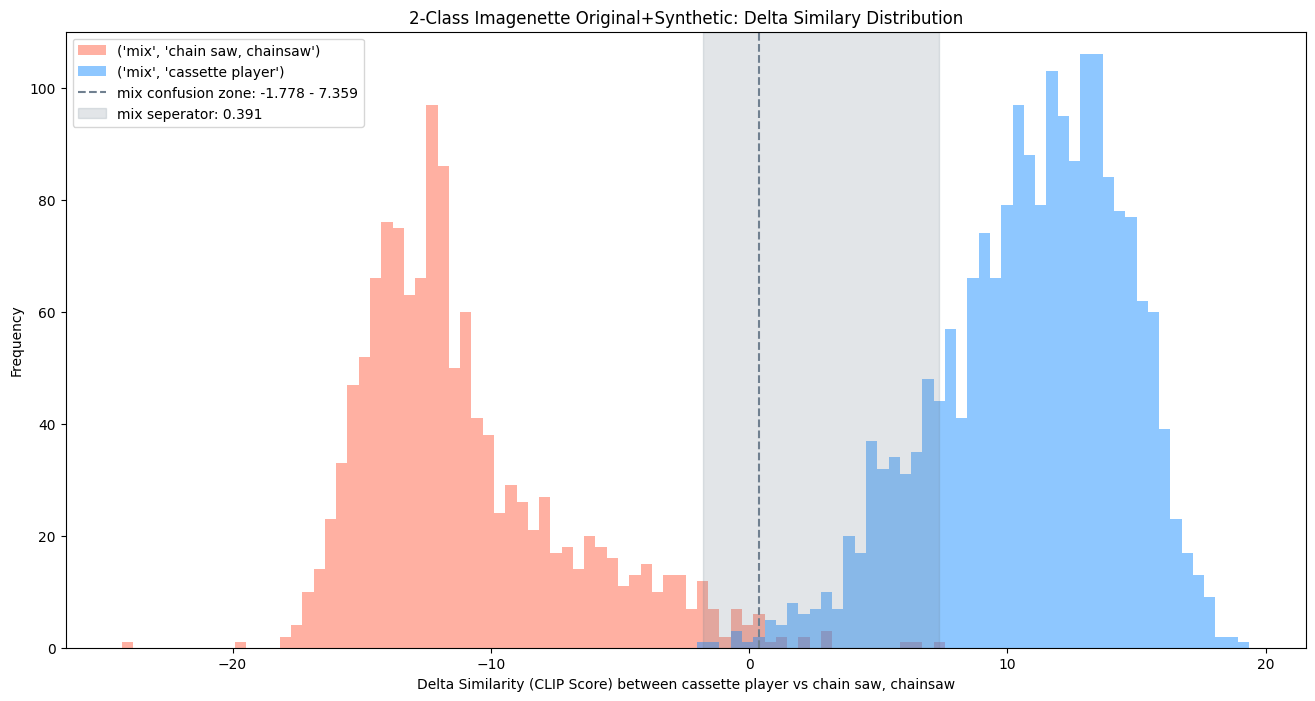

{'mix': (-1.7783145904541016, 0.3906865119934082, 7.358856201171875)}

In [82]:
df_mix = df[(df["type"] == "train") | (df["type"] == "synth")].copy()
df_mix["type"] = "mix"

analysis.viz_hist_zone(
    df_mix,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    bins=100,
    plot_type=["mix"],
    save=f"{metadata_path}/hist_mix_{synth_path.replace('/','_')}.svg",
    title=f"2-Class {ds} Original+Synthetic: Delta Similary Distribution",
)

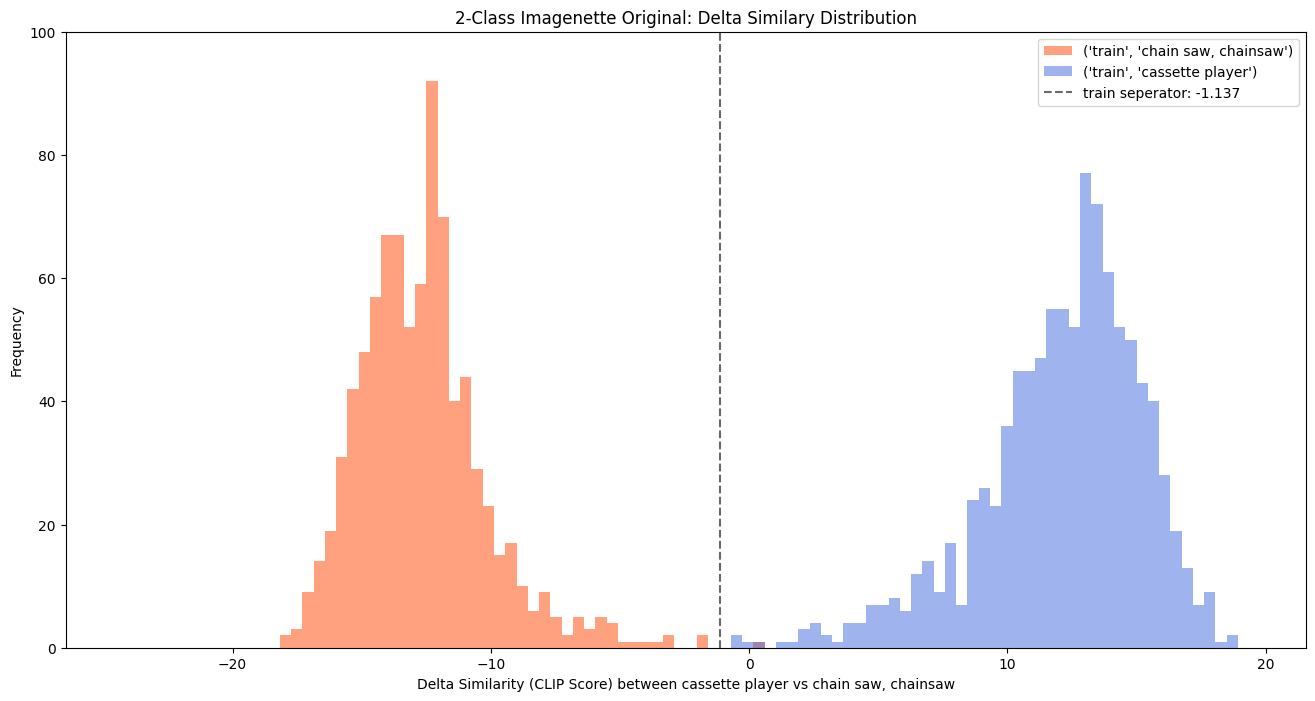

{'train': (None, -1.1365580558776855, None)}

In [83]:
analysis.viz_hist_zone(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    bins=100,
    plot_type=["train"],
    save=f"{metadata_path}/hist_train_{synth_path.replace('/','_')}.svg",
    title=f"2-Class {ds} Original: Delta Similary Distribution",
)

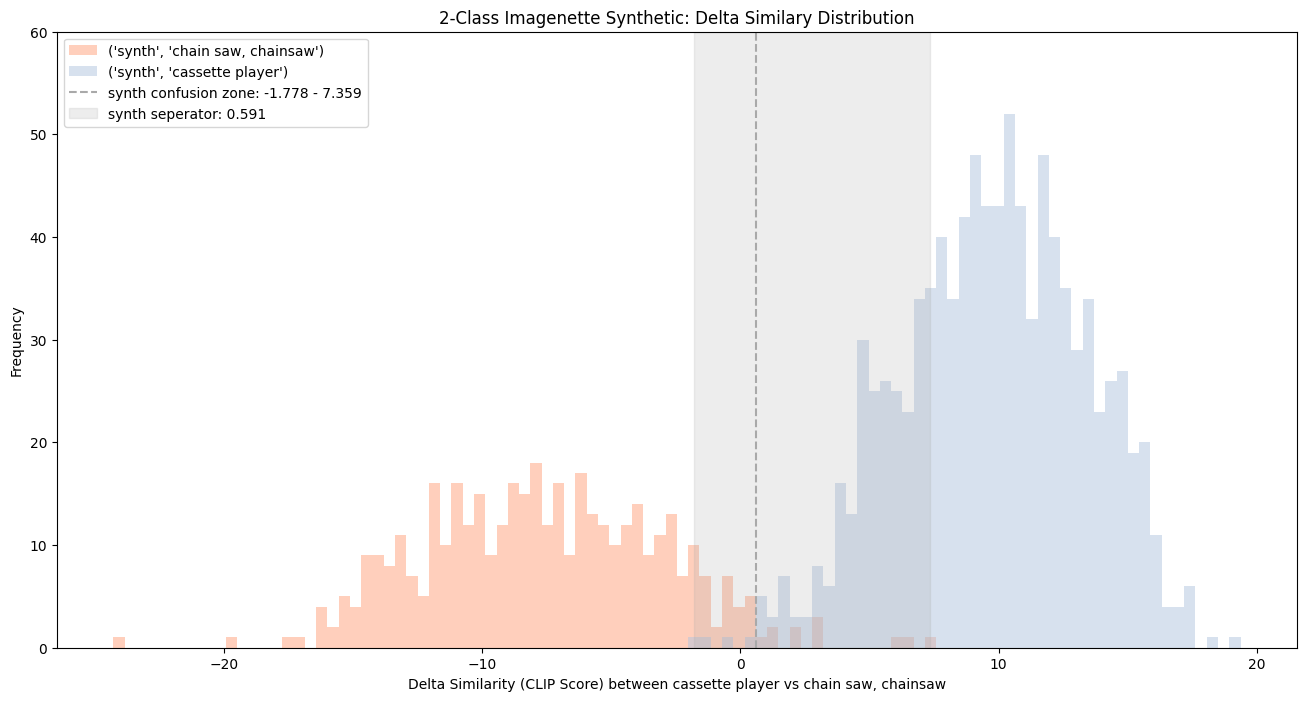

{'synth': (-1.7783145904541016, 0.5910205841064453, 7.358856201171875)}

In [84]:
analysis.viz_hist_zone(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    bins=100,
    plot_type=["synth"],
    save=f"{metadata_path}/hist_synth_{synth_path.replace('/','_')}.svg",
    title=f"2-Class {ds} Synthetic: Delta Similary Distribution",
)

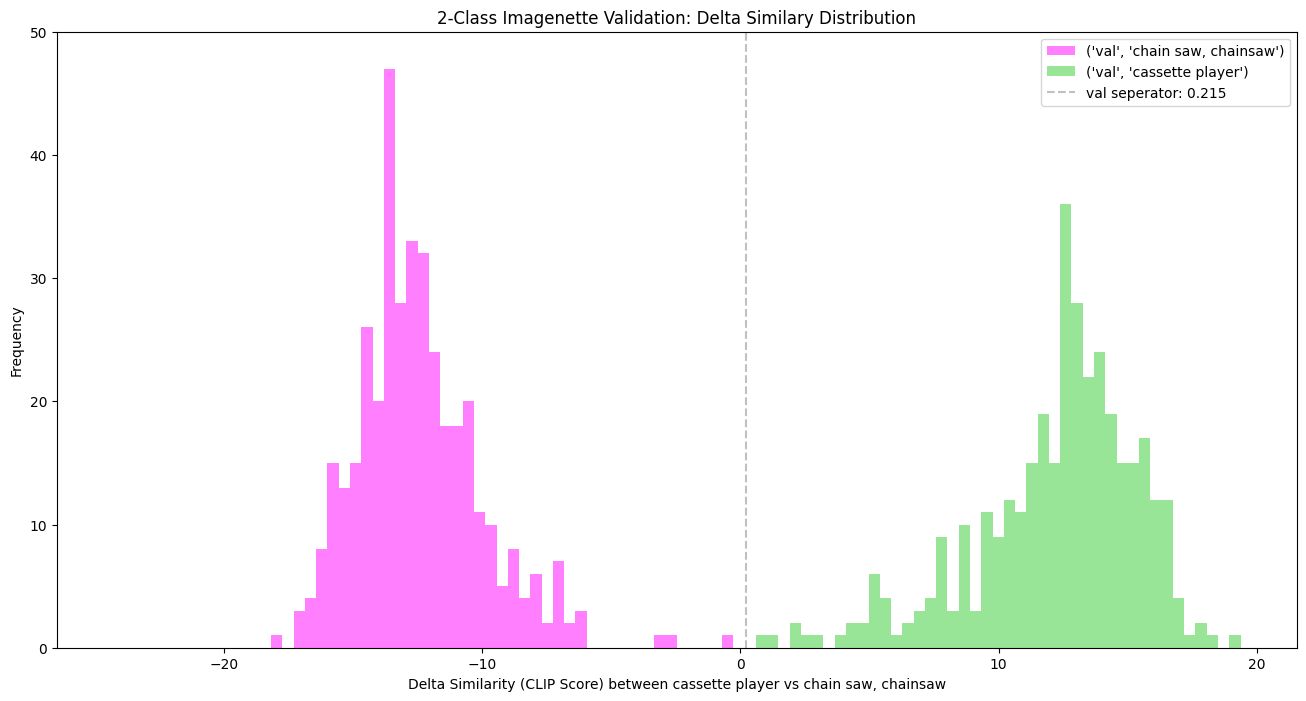

{'val': (None, 0.21523141860961914, None)}

In [85]:
analysis.viz_hist_zone(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    bins=100,
    plot_type=["val"],
    save=f"{metadata_path}/hist_val_{synth_path.replace('/','_')}.svg",
    title=f"2-Class {ds} Validation: Delta Similary Distribution",
)

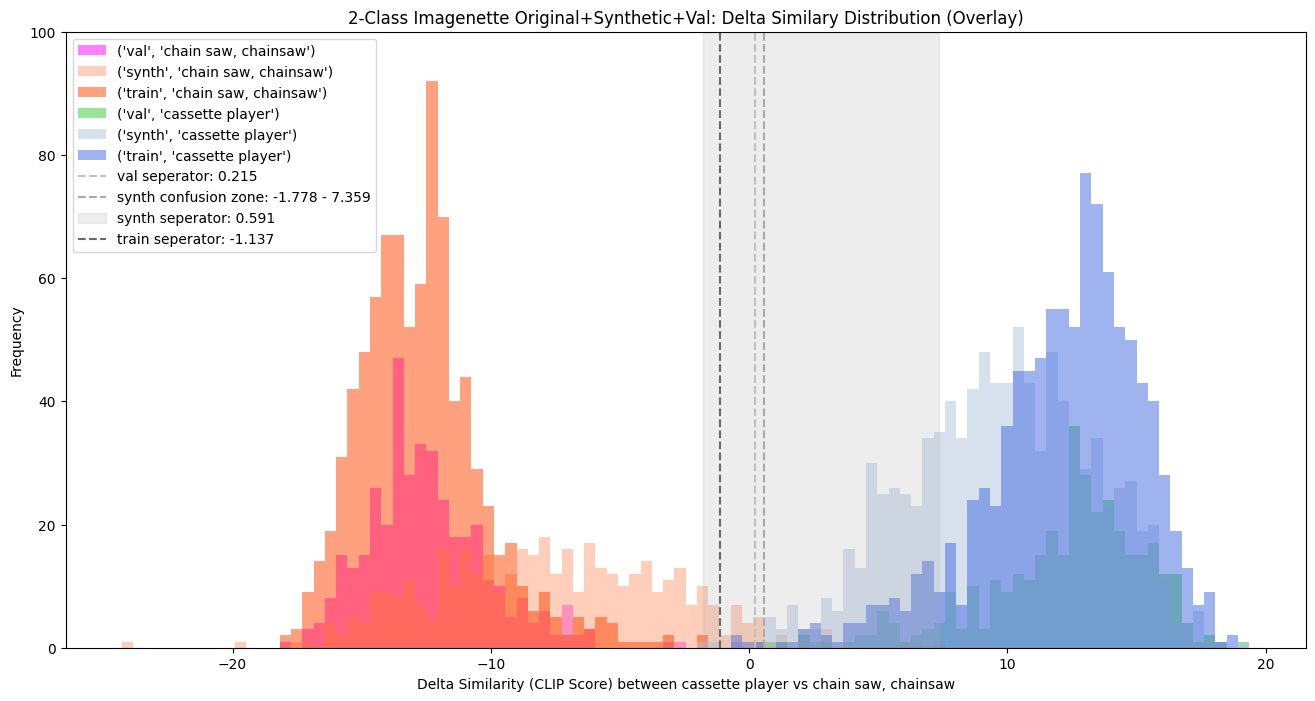

{'val': (None, 0.21523141860961914, None),
 'synth': (-1.7783145904541016, 0.5910205841064453, 7.358856201171875),
 'train': (None, -1.1365580558776855, None)}

In [86]:
analysis.viz_hist_zone(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    bins=100,
    save=f"{metadata_path}/hist_all_{synth_path.replace('/','_')}.svg",
    title=f"2-Class {ds} Original+Synthetic+Val: Delta Similary Distribution (Overlay)",
)

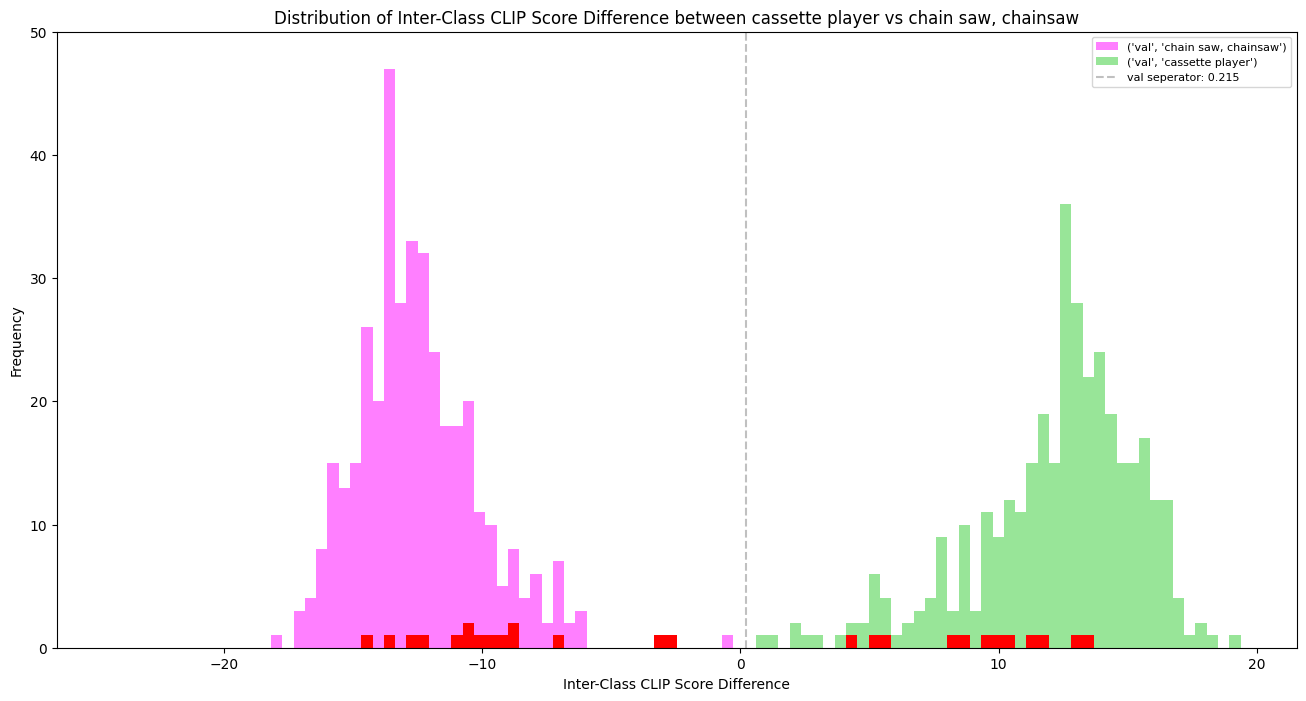

{'val': ((-14.409385681152344, -3.18594741821289, 13.486408233642578),
  0.9636608344549125,
  0,
  27,
  743)}

In [87]:
analysis.viz_hist_clf(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    bins=100,
    plot_type=["val"],
    save=f"{metadata_path}/hist_val_clf_base_{synth_path.replace('/','_')}.svg",
)

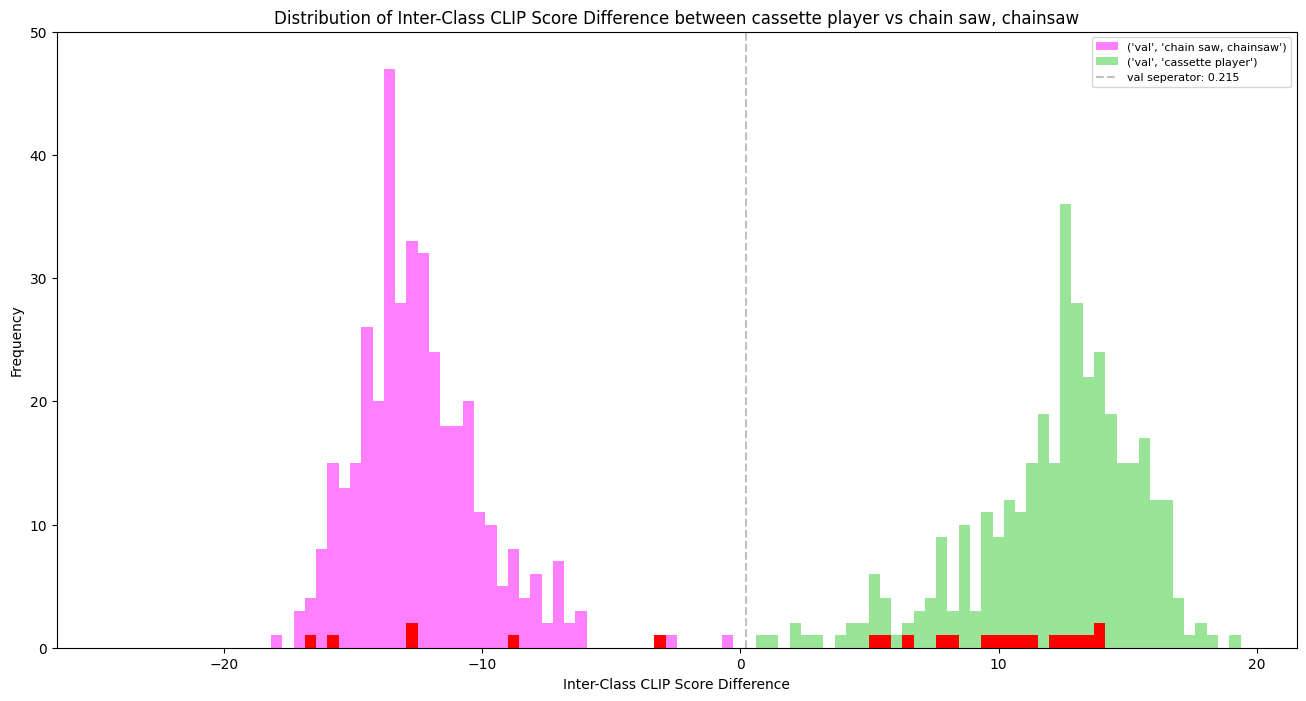

{'val': ((-16.806119918823242, 8.890573024749756, 14.124778747558594),
  0.9703903095558546,
  0,
  22,
  743)}

In [88]:
analysis.viz_hist_clf(
    df,
    class_name_pairs=class_name_pairs,
    class_pairs=class_pairs,
    bins=100,
    plot_type=["val"],
    suffix="_mix",
    save=f"{metadata_path}/hist_val_clf_mix_{synth_path.replace('/','_')}.svg",
)

## <a id='toc1_4_'></a>[Combined Visualization](#toc0_)

In [3]:
# dataset_type = "poc/imagenette"  # poc, dev, data("prod")
# class_pairs = ("n02979186", "n03000684")  # Cassette_player, Chain_saw
# prompt_format = "a photo of a <class_name>"
# ds = "Imagenette"

dataset_type = "poc/woof"  # poc, dev, data("prod")
class_pairs = ("n02087394", "n02088364")  # Rhodesian_ridgeback, Beagle
prompt_format = "a photo of a <class_name>, a type of dog"
ds = "Imagewoof"

cache_path = f"./{dataset_type}"
genInput_dir = f"{dataset_type}/train"
val_path = f"{dataset_type}/val"
synth_path = f"{dataset_type}/synthetic2c"
metadata_path = f"{dataset_type}/metadata/analysisc"

In [4]:
combinations = {
    "Imagenette": {
        "dataset_type": "poc/imagenette",  # poc, dev, data("prod")
        "class_pairs": ("n02979186", "n03000684"),  # Cassette_player, Chain_saw
        "prompt_format": "a photo of a <class_name>",
        "ds": "Imagenette",
        "c": "",
    },
    "Imagewoof": {
        "dataset_type": "poc/woof",  # poc, dev, data("prod")
        "class_pairs": ("n02087394", "n02088364"),  # Rhodesian_ridgeback, Beagle
        "prompt_format": "a photo of a <class_name>, a type of dog",
        "ds": "Imagewoof",
        "c": "",
    },
    # "imagenettec": {
    #     "dataset_type": "poc/imagenette",  # poc, dev, data("prod")
    #     "class_pairs": ("n02979186", "n03000684"),  # Cassette_player, Chain_saw
    #     "prompt_format": "a photo of a <class_name>",
    #     "ds": "Imagenette",
    #     "c": "c",
    # },
    # "imagewoofc": {
    #     "dataset_type": "poc/woof",  # poc, dev, data("prod")
    #     "class_pairs": ("n02087394", "n02088364"),  # Rhodesian_ridgeback, Beagle
    #     "prompt_format": "a photo of a <class_name>, a type of dog",
    #     "ds": "Imagewoof",
    #     "c": "c",
    # },
}

In [5]:
main = {
    "Type": [],  # train, synth, val, train+synth
    "Dataset": [],  # imagenette, imagewoof
    "Class": [],  # class
    "Prompt": [],  # prompt
    "CLIP Score to Prompt 1": [],  # clip score to prompt 1
    "CLIP Score to Prompt 2": [],  # clip score to prompt 2
}
for ds in combinations.keys():
    cache_path = f"./{combinations[ds]['dataset_type']}"
    genInput_dir = f"{combinations[ds]['dataset_type']}/train"
    val_path = f"{combinations[ds]['dataset_type']}/val"
    synth_path = f"{combinations[ds]['dataset_type']}/synthetic2{combinations[ds]['c']}"
    metadata_path = f"{combinations[ds]['dataset_type']}/metadata/analysis{combinations[ds]['c']}"
    prompt_format = combinations[ds]["prompt_format"]

    df = pd.read_csv(f"{metadata_path}/clip_clf_{synth_path.replace('/','_')}.csv").copy()
    classpairs = sorted(list(df["actual_class"].unique()))
    classnames = dict()
    prompts = dict()
    for i in classpairs:
        # lookup i in actual_classname
        classname = df[df["actual_class"] == i]["actual_classname"].unique()
        classnames[i] = classname[0]
        prompts[i] = prompt_format.replace("<class_name>", classname[0])

    train = df[df["type"] == "train"]
    for i, row in train.iterrows():
        main["Type"].append("Train")
        main["Dataset"].append(combinations[ds]["ds"])
        main["Class"].append(classnames[row["actual_class"]])
        main["Prompt"].append(prompts[row["actual_class"]])
        main["CLIP Score to Prompt 1"].append(row["sim_0"])
        main["CLIP Score to Prompt 2"].append(row["sim_1"])

    synth = df[df["type"] == "synth"]
    for i, row in synth.iterrows():
        main["Type"].append("Synthetic")
        main["Dataset"].append(combinations[ds]["ds"])
        main["Class"].append(classnames[row["actual_class"]])
        main["Prompt"].append(prompts[row["actual_class"]])
        main["CLIP Score to Prompt 1"].append(row["sim_0"])
        main["CLIP Score to Prompt 2"].append(row["sim_1"])

    train_synth = df[(df["type"] == "train") | (df["type"] == "synth")]
    for i, row in train_synth.iterrows():
        main["Type"].append("Train + Synthetic")
        main["Dataset"].append(combinations[ds]["ds"])
        main["Class"].append(classnames[row["actual_class"]])
        main["Prompt"].append(prompts[row["actual_class"]])
        main["CLIP Score to Prompt 1"].append(row["sim_0"])
        main["CLIP Score to Prompt 2"].append(row["sim_1"])

    # val = df[df["type"] == "val"]
    # for i, row in val.iterrows():
    #     main["Type"].append("Validation")
    #     main["Dataset"].append(combinations[ds]["ds"])
    #     main["Class"].append(classnames[row["actual_class"]])
    #     main["Prompt"].append(prompts[row["actual_class"]])
    #     main["CLIP Score to Prompt 1"].append(row["sim_0"])
    #     main["CLIP Score to Prompt 2"].append(row["sim_1"])  

In [6]:
df_main = pd.DataFrame(main)
df_main.head(1)

,Type,Dataset,Class,Prompt,CLIP Score to Prompt 1,CLIP Score to Prompt 2
0,Train,Imagenette,cassette player,a photo of a cassette player,24.939833,14.093545


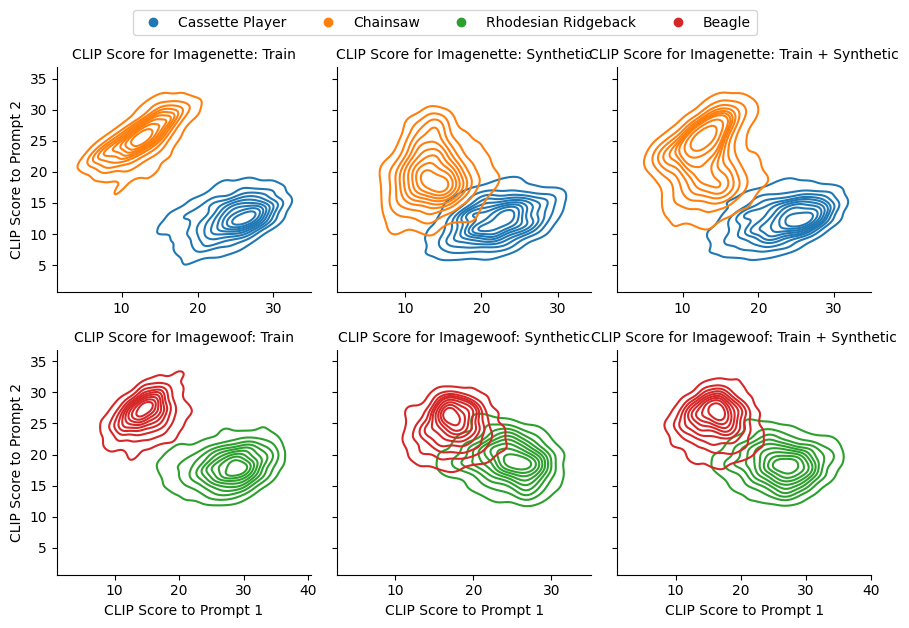

In [25]:
g = sns.FacetGrid(df_main, col="Type", row="Dataset", hue="Class", sharex=False)
ax = g.map_dataframe(sns.kdeplot, x="CLIP Score to Prompt 1", y="CLIP Score to Prompt 2")
ax.set_titles("CLIP Score for {row_name}: {col_name}")
ax.figure.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=4,
    handles=[
        plt.Line2D([0], [0], marker="o", color=sns.color_palette()[0], lw=0),
        plt.Line2D([0], [0], marker="o", color=sns.color_palette()[1], lw=0),
        plt.Line2D([0], [0], marker="o", color=sns.color_palette()[2], lw=0),
        plt.Line2D([0], [0], marker="o", color=sns.color_palette()[3], lw=0),
    ],
    labels=[
        "Cassette Player",
        "Chainsaw",
        "Rhodesian Ridgeback",
        "Beagle",
    ],
)
# ax.axes[0,0].set_xlabel("Prompt: 'a photo of a Rhodesian ridgeback, a type of dog'")
# ax.axes[1, 0].set_xlabel("Prompt: 'a photo of a cassette player'")